In [ ]:
import statsmodels.api as sm

import numpy as np
import polars as pl
import polars.exceptions as pl_exc

from toraniko.math import (
    exp_weights,
    center_xsection,
    percentiles_xsection,
    winsorize_xsection,
)
import pandas as pd
import matplotlib.pyplot as plt


In [1]:


plt.rcParams['figure.figsize'] = (4, 2)
plt.rcParams['figure.dpi'] = 500
plt.rcParams['figure.facecolor'] = '#201D1D'
plt.rcParams['axes.facecolor'] = '#201D1D'
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['axes.grid'] = False
plt.rcParams['axes.grid.axis'] = 'x'
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['axes.grid.axis'] = 'y'
plt.rcParams['axes.titlecolor'] = 'white' 
plt.rcParams['axes.xmargin'] = 0.0  
plt.rcParams['axes.ymargin'] = 0.0  

plt.rcParams['xtick.color'] = 'white' 
plt.rcParams['ytick.color'] = 'white'


In [2]:
df = pd.read_csv('../protypes/klines.csv')
df = df.rename(columns={'ticker':'symbol'})

In [3]:
crypto_data = df.copy()


In [ ]:
df = pl.DataFrame(crypto_data)

df = df.filter(
    pl.col("market_cap").is_not_null() &
    pl.col("close").is_not_null() &
    pl.col("open").is_not_null()
)

df = df.with_columns(
    (pl.col("close").log() - pl.col("close").shift(1).over("symbol").log()).alias("log_returns")
)

df = df.with_columns(
    (pl.col("close") / pl.col("close").shift(7).over("symbol") - 1).alias("weekly_returns")
)

df = df.filter(
    pl.col("log_returns").is_not_null() &
    pl.col("weekly_returns").is_not_null()
)


In [4]:
def factor_mom(
        returns_df: pl.DataFrame | pl.LazyFrame,
        trailing_days: int = 60,
        half_life: int = 4,
        lag: int = 1,
        winsor_factor: float = 0.01,
) -> pl.LazyFrame:
    """Estimate rolling symbol by symbol momentum factor scores using asset returns.

    Parameters
    ----------
    returns_df: Polars DataFrame containing columns: | date | symbol | asset_returns |
    trailing_days: int look back period over which to measure momentum
    half_life: int decay rate for exponential weighting, in days
    lag: int number of days to lag the current day's return observation (20 trading days is one month)

    Returns
    -------
    Polars DataFrame containing columns: | date | symbol | mom_score |
    """
    weights = exp_weights(trailing_days, half_life)

    def weighted_cumprod(values: np.ndarray) -> float:
        return (np.cumprod(1 + (values * weights[-len(values):])) - 1)[-1]  # type: ignore

    try:
        df = (
            returns_df.lazy()
            .sort(by="date")
            .with_columns(pl.col("asset_returns").shift(lag).over("symbol").alias("asset_returns"))
            .with_columns(
                pl.col("asset_returns")
                .rolling_map(weighted_cumprod, window_size=trailing_days)
                .over(pl.col("symbol"))
                .alias("mom_score")
            )
        ).collect()
        df = winsorize_xsection(df, ("mom_score",), "date", percentile=winsor_factor)
        return df.lazy().select(
            pl.col("date"),
            pl.col("symbol"),
            center_xsection("mom_score", "date", True).alias("mom_score"),
        )
    except AttributeError as e:
        raise TypeError("`returns_df` must be a Polars DataFrame | LazyFrame, but it's missing attributes") from e
    except pl_exc.ColumnNotFoundError as e:
        raise ValueError("`returns_df` must have 'date', 'symbol' and 'asset_returns' columns") from e


def factor_sze(
        mkt_cap_df: pl.DataFrame | pl.LazyFrame,
        lower_decile: float = 0.2,
        upper_decile: float = 0.8,
) -> pl.LazyFrame:
    """Estimate rolling symbol by symbol size factor scores using asset market caps.

    Parameters
    ----------
    mkt_cap_df: Polars DataFrame containing columns: | date | symbol | market_cap |

    Returns
    -------
    Polars DataFrame containing columns: | date | symbol | sze_score |
    """
    try:
        return (
            mkt_cap_df.lazy()
            .sort(by="date")
            .with_columns(pl.col("market_cap").log().alias("sze_score") * -1)
            .with_columns(
                "date",
                "symbol",
                (center_xsection("sze_score", "date", True)).alias("sze_score"),
            )
            .with_columns(percentiles_xsection("sze_score", "date", lower_decile, upper_decile, 0.0).alias("sze_score"))
            .select("date", "symbol", "sze_score")
        )
    except AttributeError as e:
        raise TypeError("`mkt_cap_df` must be a Polars DataFrame or LazyFrame, but it's missing attributes") from e
    except pl_exc.ColumnNotFoundError as e:
        raise ValueError("`mkt_cap_df` must have 'date', 'symbol' and 'market_cap' columns") from e




In [5]:

df = df.with_columns([
    pl.col("log_returns").rolling_std(window_size=30).over("symbol").alias("realized_volatility")
])

momo_scores = factor_mom(
    df.select(["date", "symbol", "log_returns"]).rename({"log_returns": "asset_returns"})).collect()

size_scores = factor_sze(df.select(["date", "symbol", "market_cap"])).collect()


/usr/local/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


In [11]:
def calculate_market_factor(df: pl.DataFrame, risk_free_rate: float = 0.01 / 12) -> pl.DataFrame:
    df = df.with_columns([
        (df["volume"] / df["market_cap"]).alias("weight"),
        (df["close"] / df["open"] - 1).alias("daily_return")
    ])

    df = df.with_columns([
        (df["weight"] * df["daily_return"]).alias("weighted_return")
    ])

    market_return = df.group_by("date").agg(pl.col("weighted_return").sum().alias("market_return"))

    market_return = market_return.with_columns([
        (pl.col("market_return") - risk_free_rate).alias("CMKT")
    ])
    df = df.join(market_return, on="date")

    return df

df_with_market_factor = calculate_market_factor(df)
df_with_market_factor = df_with_market_factor.drop(['Unnamed: 0'])


In [12]:
momo_scores = momo_scores.filter(
    pl.col("mom_score").is_not_nan())
size_scores = size_scores.filter(
    pl.col("sze_score").is_not_nan())

df_with_market_factor = df_with_market_factor.filter(
    pl.col("CMKT").is_not_nan())


In [13]:
df_combined = df_with_market_factor.join(momo_scores, on=["date", "symbol"], how="inner")
df_combined = df_combined.join(size_scores, on=["date", "symbol"], how="inner")


In [14]:
df_combined = df_combined.drop_nulls()

print(df_combined)


shape: (107_207, 24)
┌────────────┬──────────┬──────────┬──────────┬───┬────────────┬───────────┬───────────┬───────────┐
│ date       ┆ open     ┆ high     ┆ low      ┆ … ┆ market_ret ┆ CMKT      ┆ mom_score ┆ sze_score │
│ ---        ┆ ---      ┆ ---      ┆ ---      ┆   ┆ urn        ┆ ---       ┆ ---       ┆ ---       │
│ str        ┆ f64      ┆ f64      ┆ f64      ┆   ┆ ---        ┆ f64       ┆ f64       ┆ f64       │
│            ┆          ┆          ┆          ┆   ┆ f64        ┆           ┆           ┆           │
╞════════════╪══════════╪══════════╪══════════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ 2022-03-10 ┆ 0.4037   ┆ 0.4384   ┆ 0.3776   ┆ … ┆ -26.063004 ┆ -26.06383 ┆ 1.967977  ┆ 1.189614  │
│            ┆          ┆          ┆          ┆   ┆            ┆ 7         ┆           ┆           │
│ 2022-03-10 ┆ 21.258   ┆ 21.43    ┆ 19.649   ┆ … ┆ -26.063004 ┆ -26.06383 ┆ -0.58705  ┆ 0.0       │
│            ┆          ┆          ┆          ┆   ┆            ┆ 7    

In [15]:
def estimate_betas_by_week(df_combined):
    results = []
    residuals_data = []

    df_combined_pd = df_combined.to_pandas()
    df_combined_pd['date'] = pd.to_datetime(df_combined_pd['date'])

    grouped = df_combined_pd.groupby([df_combined_pd['symbol'], df_combined_pd['date'].dt.to_period('W')])

    for (symbol, week), df_week in grouped:
        df_week['date'] = week.start_time
        df_week = df_week.dropna()
        if df_week.shape[0] < 2: 
            print(f"Skipping {symbol} for week {week} due to insufficient data.")
            continue

        X = df_week[['CMKT', 'mom_score', 'sze_score', 'realized_volatility']]
        y = df_week['weekly_returns']

        X = sm.add_constant(X)

        try:
            model = sm.OLS(y, X).fit()
            result = {
                'symbol': symbol,
                'week': week.start_time, 
                'beta_CMKT': model.params.get('CMKT', None),
                'beta_mom_score': model.params.get('mom_score', None),
                'beta_sze_score': model.params.get('sze_score', None),
                'beta_realized_vol': model.params.get('realized_volatility', None),
                'alpha': model.params.get('const', None),
                'R_squared': model.rsquared
            }
            results.append(result)

            df_residuals = pd.DataFrame({
                'symbol': symbol,
                'date': df_week['date'],
                'residuals': model.resid
            })
            residuals_data.append(df_residuals)

        except Exception as e:
            print(f"Skipping {symbol} for week {week} due to error: {e}")
            continue

    results_df = pd.DataFrame(results)

    residuals_df = pd.concat(residuals_data, ignore_index=True)

    return results_df, residuals_df

betas_df, residuals_df = estimate_betas_by_week(df_combined)
print(betas_df.head())
print(residuals_df.head())


/usr/local/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1

      symbol       week  beta_CMKT  beta_mom_score  beta_sze_score  \
0  1INCHUSDT 2022-03-07  -0.000886        0.025014             0.0   
1  1INCHUSDT 2022-03-14   0.000626        0.084026             0.0   
2  1INCHUSDT 2022-03-21   0.000404        0.171070             0.0   
3  1INCHUSDT 2022-03-28   0.000078        0.134578             0.0   
4  1INCHUSDT 2022-04-04   0.000392        0.001597             0.0   

   beta_realized_vol     alpha  R_squared  
0         -20.717855  0.888078   1.000000  
1          15.638054 -0.675448   0.651271  
2          -3.036498  0.264958   0.706169  
3          21.599098 -0.707363   0.159420  
4         -24.322490  1.034999   0.879212  
      symbol       date residuals
0  1INCHUSDT 2022-03-07       0.0
1  1INCHUSDT 2022-03-07      -0.0
2  1INCHUSDT 2022-03-07       0.0
3  1INCHUSDT 2022-03-07      -0.0
4  1INCHUSDT 2022-03-14 -0.026219


In [18]:
def backtest_long_short_portfolio(df_combined, betas_df, holding_period='1W'):
    df_combined_pd = df_combined.to_pandas()
    df_combined_pd['date'] = pd.to_datetime(df_combined_pd['date'])

    portfolio_returns = []

    grouped = df_combined_pd.groupby(df_combined_pd['date'].dt.to_period(holding_period[1]))

    for period, df_week in grouped:
        df_week['period_start_time'] = period.start_time

        betas_week = betas_df[betas_df['week'] == period.start_time]

        df_merged = pd.merge(df_week, betas_week, on='symbol', how='inner')
        df_merged['rank'] = df_merged['beta_mom_score'].rank(ascending=False)
        num_assets = 20 

        df_long = df_merged[df_merged['rank'] <= num_assets]
        df_long['portfolio_weight'] = 1 / num_assets  
        df_short = df_merged[df_merged['rank'] > (df_merged['rank'].max() - num_assets)]
        df_short['portfolio_weight'] = -1 / num_assets  

        long_return = (df_long['portfolio_weight'] * df_long['weekly_returns']).sum()
        short_return = (df_short['portfolio_weight'] * df_short['weekly_returns']).sum()

        net_return = long_return + short_return

        portfolio_returns.append({
            'period': period.start_time,
            'long_return': long_return,
            'short_return': short_return,
            'net_return': net_return
        })

    portfolio_returns_df = pd.DataFrame(portfolio_returns)

    return portfolio_returns_df



/var/folders/vp/bmgsm3216fg61zdd22k8n6jw0000gn/T/ipykernel_19071/1952235153.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_long['portfolio_weight'] = 1 / num_assets
/var/folders/vp/bmgsm3216fg61zdd22k8n6jw0000gn/T/ipykernel_19071/1952235153.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_short['portfolio_weight'] = -1 / num_assets
/var/folders/vp/bmgsm3216fg61zdd22k8n6jw0000gn/T/ipykernel_19071/1952235153.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

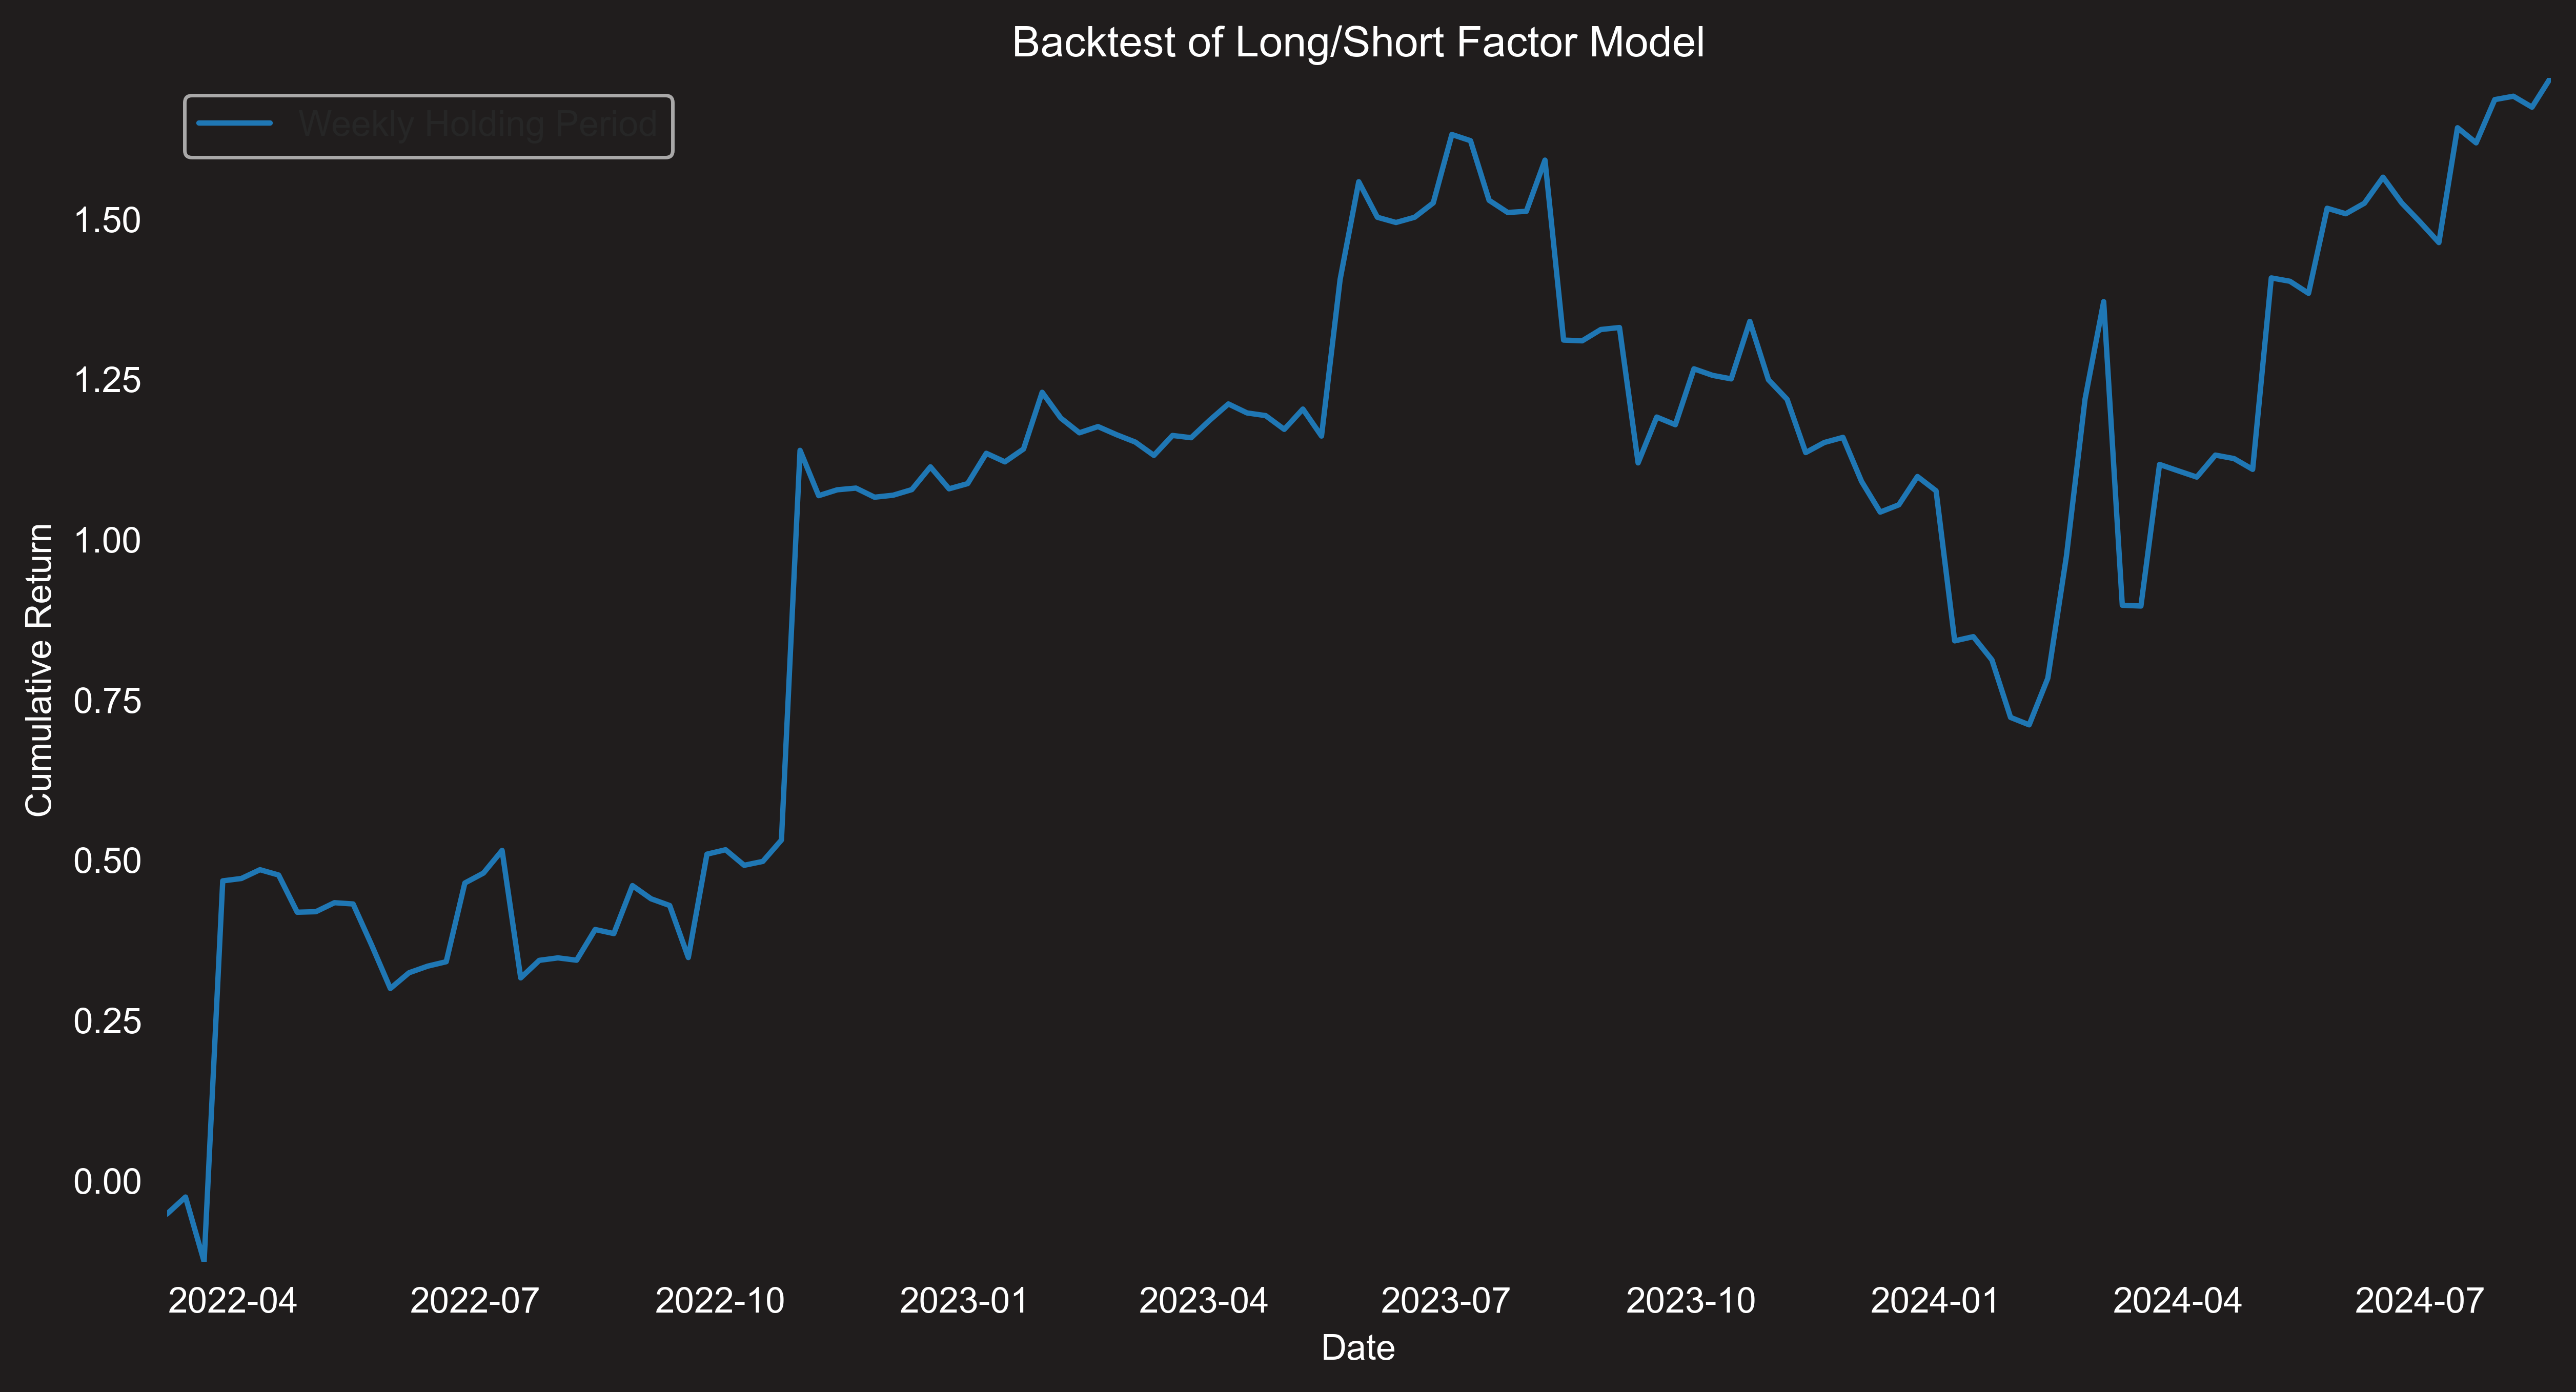

In [23]:

portfolio_returns_df_weekly = backtest_long_short_portfolio(df_combined, betas_df, holding_period='1W')


portfolio_returns_df_weekly['cumulative_return'] = portfolio_returns_df_weekly['net_return'].cumsum()

plt.figure(figsize=(12, 6))
plt.plot(portfolio_returns_df_weekly['period'], portfolio_returns_df_weekly['cumulative_return'], label='Weekly Holding Period')
plt.title('Backtest of Long/Short Factor Model')
plt.xlabel('Date',c='white')
plt.ylabel('Cumulative Return',c='white')
plt.legend()
plt.show()